# mass binning

In [145]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

def file_name(obj,prefix,filetype='fits'):
    field = obj['subfield'].lower()
    id    = str(obj['ID']).zfill(5)
    return f"hlsp_clear_hst_wfc3_{field}-{id}_g102-g141_v4_{prefix}.{filetype}"

def find_data(name,hdu):
    for image in hdu:
        if name == image.name:
            return image

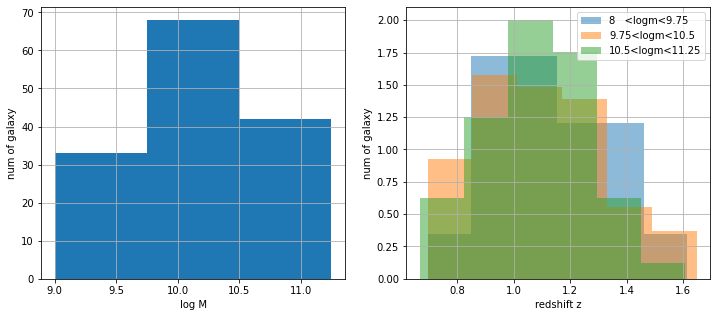

In [ ]:
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['mass']>0]
bins = [-np.inf,9.75,10.5,np.inf]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins)
bin_label = ['8   <logm<9.75','9.75<logm<10.5','10.5<logm<11.25']

ax = plt.figure(figsize=(12,5))
ax.add_subplot(121)
plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25])
plt.xlabel('log M');plt.ylabel('num of galaxy')
plt.grid()
ax.add_subplot(122)
plt.hist(obj_lis[binning_m==1]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label[0])
plt.hist(obj_lis[binning_m==2]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label[1])
plt.hist(obj_lis[binning_m==3]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label[2])
plt.xlabel('redshift z');plt.ylabel('num of galaxy')
plt.legend();plt.grid()
plt.show()

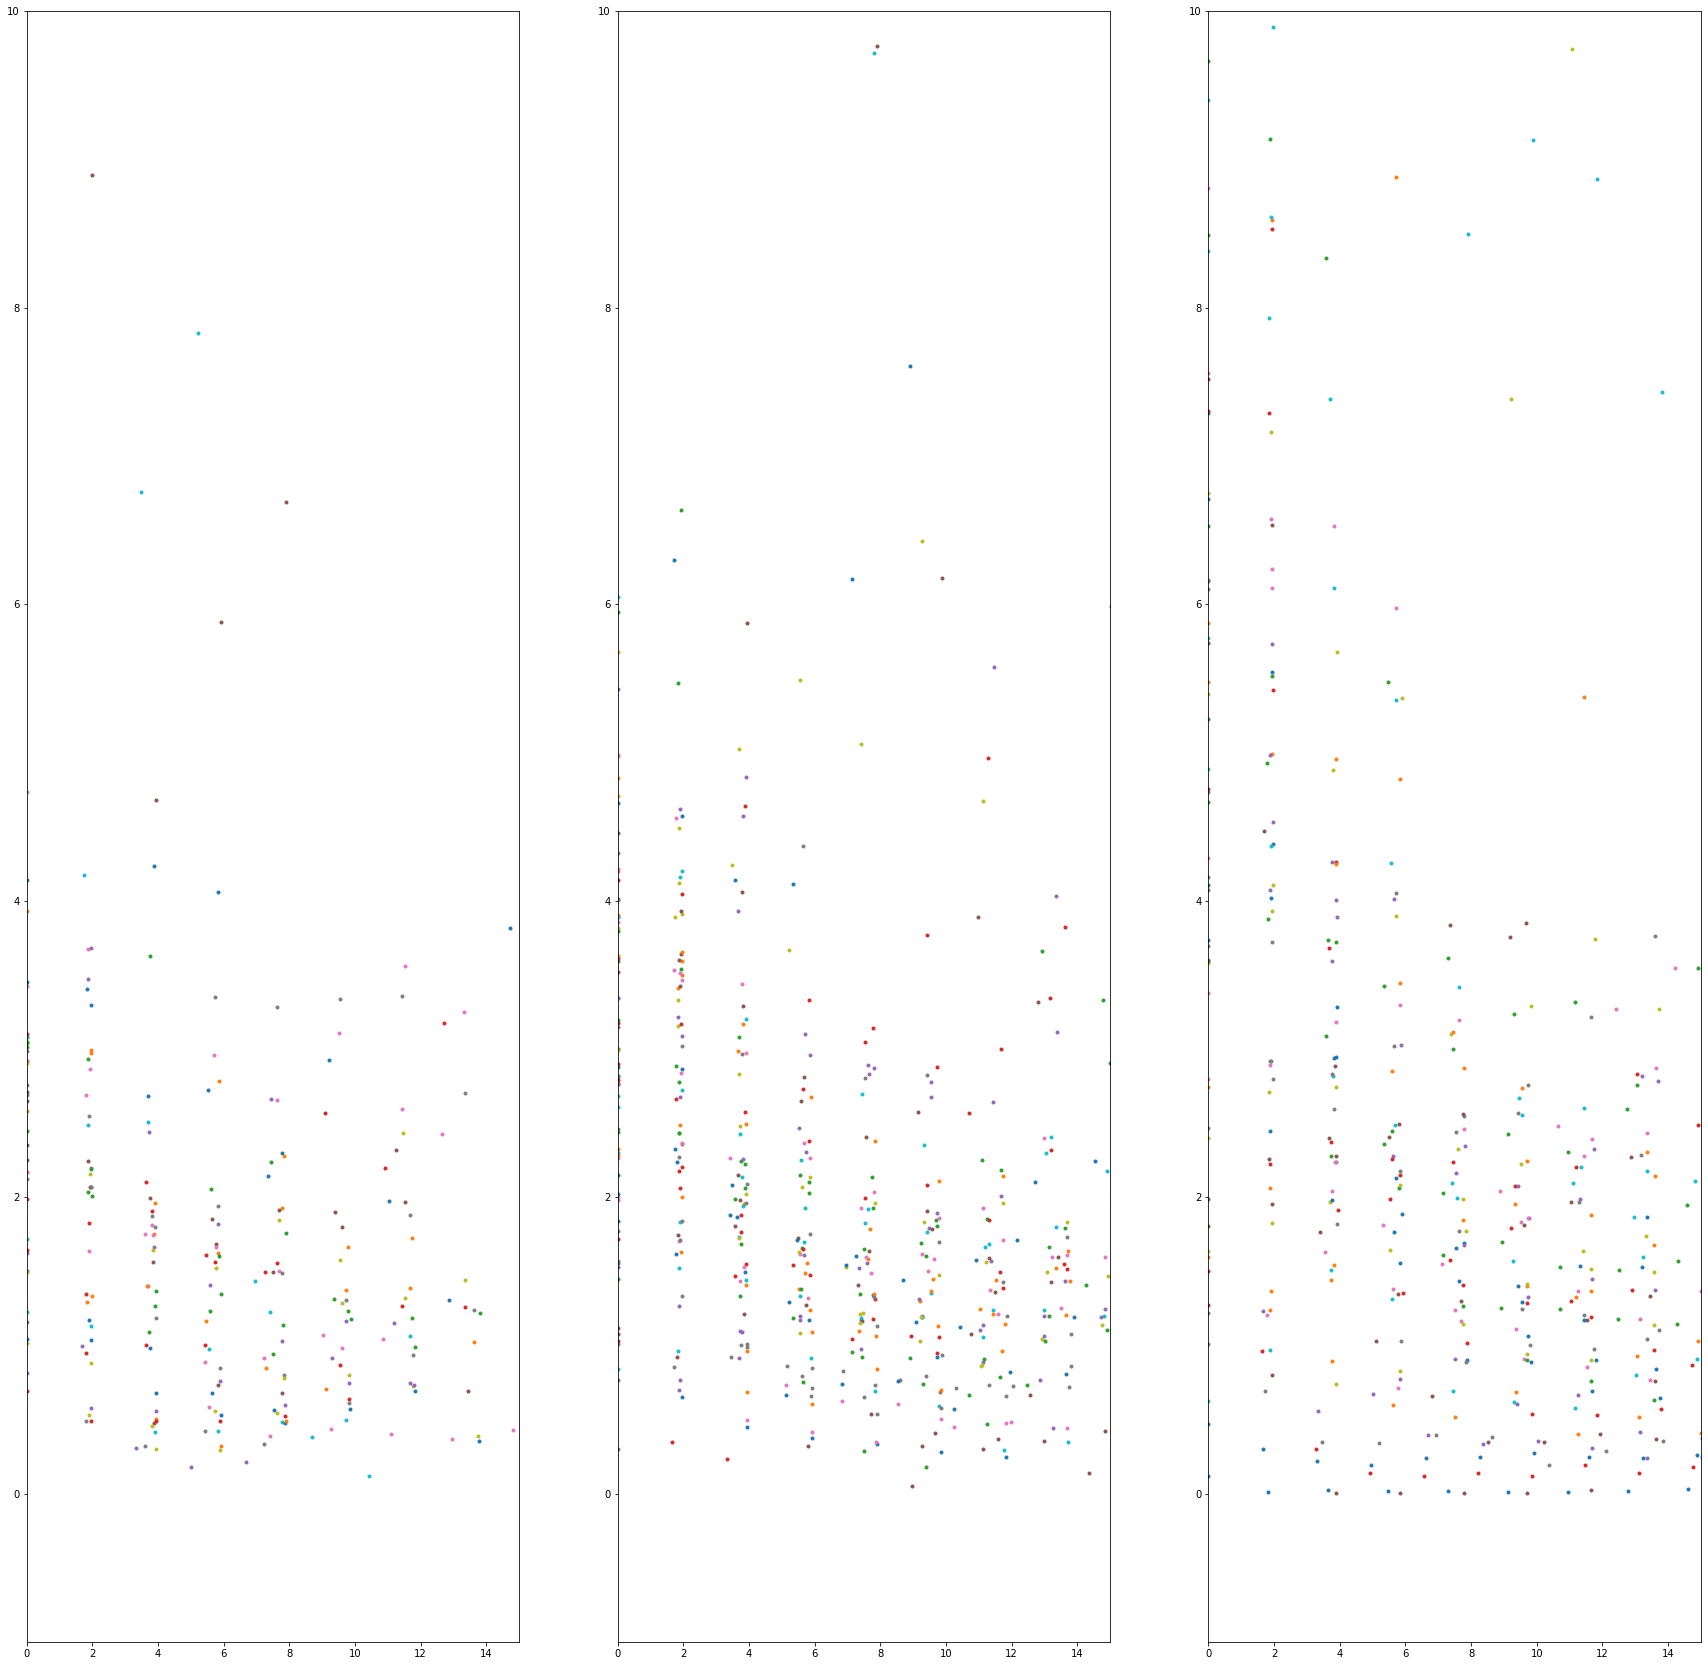

In [159]:
ax =plt.figure(figsize=(30,30))

for i in range(len(bins)-1):
    ax.add_subplot(int(f'13{i+1}'))
    for obj in obj_lis[binning_m==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('RAD_PROFILE',hdu).data).transpose()
            plt.errorbar(r,balmer_r,yerr = balmer_r_err,linewidth=0,marker='.',elinewidth=0)

            plt.xlim(0,15);plt.ylim(-1,10)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001B6249EDEB0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001B62061D3D0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B624A121C0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B6249ED160>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B624A12040>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B624A12430>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B624A12670>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001B624A128B0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001B624A12AF0>]